# Project description

**Recommendation of tariffs**

**Megaline**, the mobile operator, has discovered that many of its customers are using outdated tariffs. They intend to develop a system that can analyze customer behavior and recommend new tariffs, namely "Smart" or "Ultra".

You have access to data on customer behavior who have already switched to these tariffs from the "[Statistical Data Analysis](https://github.com/vartemyev88/data-analysis/tree/main/projects/practicum-determining_promising_tariff)" course project. Your task is to create a classification model that can choose the appropriate tariff. You don't need to perform data preprocessing as you have already completed it.

Your objective is to build a model with the highest possible accuracy. To successfully complete the project, you must achieve an `accuracy` rate of at least `0.75`. You need to independently verify the accuracy of the test sample.

# Table of contents

---

1. [Data overview](#data-overview)
2. [Exploratory data analysis](#eda)
3. [Data split](#data-split)
4. [Models overview](#models-overview)
5. [General conclusion](#conclusion)
6. [Test dataset](#test-dataset)
7. [Conclusion](#conclusion)
---

## Data overview <a class="anchor" id="data-overview"></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
# Locating the CSV with several locations
try:
    df = pd.read_csv("/datasets/users_behavior.csv")
except FileNotFoundError:
    try:
        df = pd.read_csv("users_behavior.csv")
    except FileNotFoundError:
        try:
            df = pd.read_csv(r"users_behavior.csv")
        except FileNotFoundError:
            print("File not found")

# Ignorig all warnings and displaying all columns in the DF:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

# Print shape of dataframe
print(f"Shape of dataframe: {df.shape}")
print("-" * 26)

# Check for missing values and print percentage of missing values
print("\nMissing values:")
print(df.isna().mean().sort_values())
print("-" * 26)

# Check for duplicates and print the number of duplicate rows
print(f"\nDuplicates: {df.duplicated().sum()}")
print("-" * 26)

# Print data type of each column
print("\nData types:")
print(df.dtypes)

# Print descriptive statistics
display(df.describe())

# Print the first 5 rows of the dataframe
display(df.head())

Shape of dataframe: (3214, 5)
--------------------------

Missing values:
calls       0.0
minutes     0.0
messages    0.0
mb_used     0.0
is_ultra    0.0
dtype: float64
--------------------------

Duplicates: 0
--------------------------

Data types:
calls       float64
minutes     float64
messages    float64
mb_used     float64
is_ultra      int64
dtype: object


,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


## Exploratory data analysis <a class="anchor" id="eda"></a>

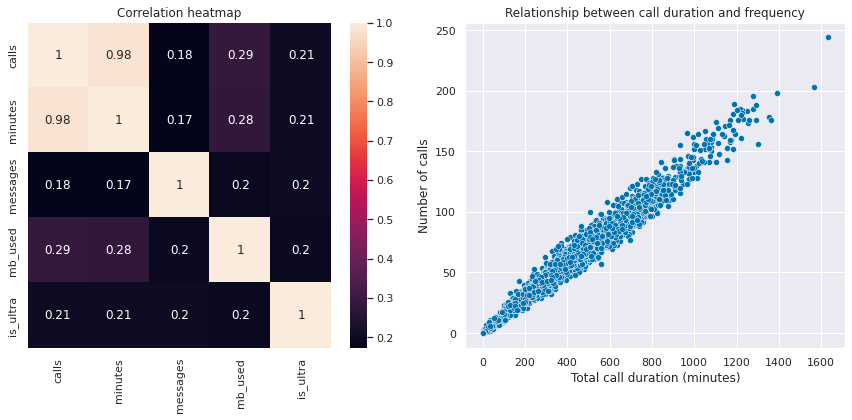

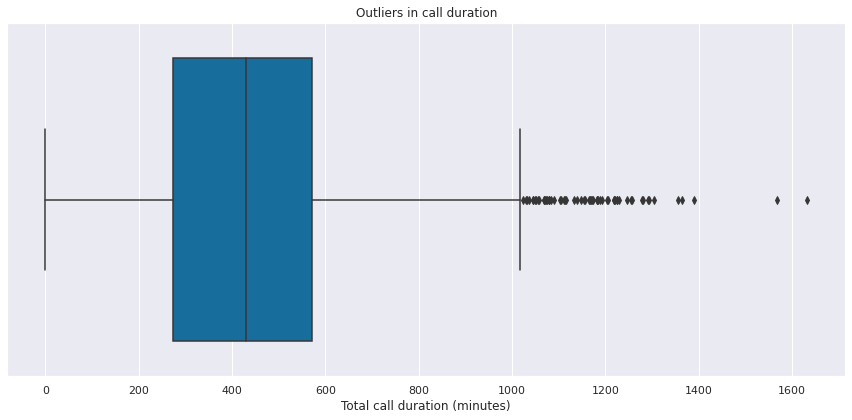


Correlation between call frequency and duration: 0.98


In [3]:
sns.set(rc={"figure.figsize": (12, 6)}, color_codes=True, palette="colorblind")

# Plotting heatmap and scatterplot:
fig, (ax1, ax2) = plt.subplots(ncols=2)
sns.heatmap(df.corr(), cbar=True, cmap="rocket", annot=True, ax=ax1)
ax1.set_title("Correlation heatmap")
sns.scatterplot(data=df, x="minutes", y="calls", ax=ax2)
ax2.set_title("Relationship between call duration and frequency")
ax2.set_xlabel("Total call duration (minutes)")
ax2.set_ylabel("Number of calls")
plt.tight_layout()
plt.show()

# Plotting boxplot and printing correlation:
fig, ax = plt.subplots()
sns.boxplot(data=df, x="minutes", ax=ax)
ax.set_title("Outliers in call duration")
ax.set_xlabel("Total call duration (minutes)")
plt.tight_layout()
plt.show()

print(f"\nCorrelation between call frequency and duration: {df['calls'].corr(df['minutes']):.2f}")

There is a correlation between `calls` and `minutes`. The significant majority of calls fall within the range of up to 1400 minutes, with the outliers being calls around 1600 minutes.

## Data split <a class="anchor" id="data-split"></a>

In [4]:
# Split the data into training, validation and test:
train_data, temp_data = train_test_split(df, test_size=0.4, random_state=12345)
valid_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=12345)

# Print the proportions of the datasets:
for data, name in [
    (train_data, "training"),
    (valid_data, "validation"),
    (test_data, "test"),
]:
    prop = len(data) / len(df)
    print(f"Proportion of {name} data: {prop:.0%}")

# Split the datasets into features and target:
X_train, y_train = train_data.drop("is_ultra", axis=1), train_data["is_ultra"]
X_valid, y_valid = valid_data.drop("is_ultra", axis=1), valid_data["is_ultra"]
X_test, y_test = test_data.drop("is_ultra", axis=1), test_data["is_ultra"]

Proportion of training data: 60%
Proportion of validation data: 20%
Proportion of test data: 20%


## Models overview <a class="anchor" id="models-overview"></a>

In [5]:
# DecisionTreeClassifier:
best_model = None
best_result = 0

for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    result = accuracy_score(y_valid, predictions)
    print(f"max_depth: {depth}, accuracy: {result:.2f}")
    if result > best_result:
        best_model = model
        best_result = result
        
print(f"\nDecisionTreeClassifier(max_depth={best_model.max_depth}) accuracy: {best_result:.2f}")

max_depth: 1, accuracy: 0.75
max_depth: 2, accuracy: 0.78
max_depth: 3, accuracy: 0.79
max_depth: 4, accuracy: 0.78
max_depth: 5, accuracy: 0.78
max_depth: 6, accuracy: 0.78
max_depth: 7, accuracy: 0.78
max_depth: 8, accuracy: 0.78
max_depth: 9, accuracy: 0.78
max_depth: 10, accuracy: 0.77

DecisionTreeClassifier(max_depth=3) accuracy: 0.79


In [6]:
# RandomForestClassifier:
best_model = None
best_result = 0

for depth in range(1, 7):
    for est in range(1, 15):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(X_train, y_train)
        predictions = model.predict(X_valid)
        result = accuracy_score(y_valid, predictions)
        print(f"n_estimators: {est}, max_depth: {depth}, accuracy: {result:.2f}")
        if result > best_result:
            best_model = model
            best_result = result

print(f"\nRandomForestClassifier(n_estimators={best_model.n_estimators}, max_depth={best_model.max_depth}) accuracy: {best_result:.2f}")

n_estimators: 1, max_depth: 1, accuracy: 0.75
n_estimators: 2, max_depth: 1, accuracy: 0.74
n_estimators: 3, max_depth: 1, accuracy: 0.75
n_estimators: 4, max_depth: 1, accuracy: 0.77
n_estimators: 5, max_depth: 1, accuracy: 0.76
n_estimators: 6, max_depth: 1, accuracy: 0.76
n_estimators: 7, max_depth: 1, accuracy: 0.76
n_estimators: 8, max_depth: 1, accuracy: 0.76
n_estimators: 9, max_depth: 1, accuracy: 0.75
n_estimators: 10, max_depth: 1, accuracy: 0.76
n_estimators: 11, max_depth: 1, accuracy: 0.75
n_estimators: 12, max_depth: 1, accuracy: 0.75
n_estimators: 13, max_depth: 1, accuracy: 0.75
n_estimators: 14, max_depth: 1, accuracy: 0.75
n_estimators: 1, max_depth: 2, accuracy: 0.79
n_estimators: 2, max_depth: 2, accuracy: 0.78
n_estimators: 3, max_depth: 2, accuracy: 0.78
n_estimators: 4, max_depth: 2, accuracy: 0.79
n_estimators: 5, max_depth: 2, accuracy: 0.77
n_estimators: 6, max_depth: 2, accuracy: 0.77
n_estimators: 7, max_depth: 2, accuracy: 0.76
n_estimators: 8, max_depth: 2

In [7]:
# LogisticRegression:
best_model = None
best_result = 0

for iter_ in range(1, 15):
    model = LogisticRegression(random_state=12345, solver="lbfgs", max_iter=iter_)
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    result = accuracy_score(y_valid, predictions)
    print(f"max_iter: {iter}, accuracy: {result:.2f}")
    if result > best_result:
        best_model = model
        best_result = result
        
print(f"\nLogisticRegression(max_iter={best_model.max_iter}) accuracy: {best_result:.2f}")

max_iter: <built-in function iter>, accuracy: 0.71
max_iter: <built-in function iter>, accuracy: 0.71
max_iter: <built-in function iter>, accuracy: 0.71
max_iter: <built-in function iter>, accuracy: 0.71
max_iter: <built-in function iter>, accuracy: 0.71
max_iter: <built-in function iter>, accuracy: 0.71
max_iter: <built-in function iter>, accuracy: 0.71
max_iter: <built-in function iter>, accuracy: 0.71
max_iter: <built-in function iter>, accuracy: 0.71
max_iter: <built-in function iter>, accuracy: 0.71
max_iter: <built-in function iter>, accuracy: 0.71
max_iter: <built-in function iter>, accuracy: 0.71
max_iter: <built-in function iter>, accuracy: 0.71
max_iter: <built-in function iter>, accuracy: 0.71

LogisticRegression(max_iter=1) accuracy: 0.71


The most effective model turned out to be the `RandomForestClassifier` model with an accuracy value of *0.8*.

## Test dataset <a class="anchor" id="test-dataset"></a>

Testing the most effective model on the test dataset, and checking it with random sampling.

In [8]:
# RandomForestClassifier:
model = RandomForestClassifier(random_state=12345, n_estimators=14, max_depth=6)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

print(f"{model} accuracy on the test set: {accuracy:.2f}")

# RandomForestClassifier:
ran_num = np.random.randint(2, size=643)
result = accuracy_score(y_test, ran_num)
        
print(f"{model} accuracy with random sampling: {result:.2f}")

RandomForestClassifier(max_depth=6, n_estimators=14, random_state=12345) accuracy on the test set: 0.79
RandomForestClassifier(max_depth=6, n_estimators=14, random_state=12345) accuracy with random sampling: 0.50


## Conclusion <a class="anchor" id="conclusion"></a>

The following conclusions can be drawn from the research:

1. There is a direct correlation of 0.98 between the data in the `calls` and `minutes` columns.
2. The data was split into three samples with the following proportions:
    - Training data: 60%
    - Validation data: 20%
    - Test data: 20%
3. Following machine learning models were selected: `DecisionTreeClassifier`, `RandomForestClassifier`, and `LogisticRegression`. The `accuracy_score` metric (with a minimum threshold of *0.75*) was used as the performance indicator for the models, hyperparameters were tuned in a loop, and the best model showed the following result:
    - `RandomForestClassifier(n_estimators=12, max_depth=6) accuracy: 0.8`
4. The most effective model was tested on the test sample, with a result of *0.79*. A test on random numbers was also performed, with a result of *0.5*.